In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import spacy

In [3]:
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel

In [4]:
#spacy.prefer_gpu()
#nlp = spacy.load("fr_dep_news_trf")
nlp = spacy.load("fr_core_news_lg")

In [68]:
interventions = pd.read_csv('out/interventions.csv')
acteurs = pd.read_csv('out/interventions.csv')
votes = pd.read_csv('out/votes.csv')
organes = pd.read_csv('out/organes.csv')

In [6]:
interventions

,id_syceron,acteur,code_grammaire,code_style,stime,texte,seance,mots
0,2845790,PA721908,OUV_SEAN_2_1,NORMAL,919.71,La séance est ouverte.,RUANR5L16S2022IDS26244,4
1,2845795,PA721908,ODJ_APPEL_DISCUSSION,NORMAL,922.29,"L’ordre du jour appelle la discussion, sur le ...",RUANR5L16S2022IDS26244,26
2,2845797,PA721908,PAROLE_GENERIQUE,NORMAL,931.96,"La parole est à M. Jean-Renvé Cazeneuve, rap...",RUANR5L16S2022IDS26244,13
3,2845798,PA719472,PAROLE_GENERIQUE,NORMAL,957.22,Je suis ravi de vous présenter les conclusion...,RUANR5L16S2022IDS26244,101
4,2845799,PA642847,INTERRUPTION_1_10,NORMAL,981.52,Un Lorrain !,RUANR5L16S2022IDS26244,3
...,...,...,...,...,...,...,...,...
156971,2944887,PA793382,INTERRUPTION_1_10,NORMAL,9539.76,Et c’est d’acheter du charbon à l’Allemagne ?,RUANR5L16S2023IDS26598,8
156972,2944889,PA720908,SCRUT_PUB_ADT_1_2,NORMAL,9549.08,Je mets aux voix l’amendement no 3039.,RUANR5L16S2023IDS26598,7
156973,2944891,PA720908,SCRUT_PUB_ADT_1_4,NORMAL,9554.61,Voici le résultat du scrutin : Nombre ...,RUANR5L16S2023IDS26598,165
156974,2944893,PA720908,FIN_SEAN_1_0,NORMAL,9555.48,La suite de la discussion est renvoyée à la ...,RUANR5L16S2023IDS26598,11


In [7]:
removal= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']

In [8]:
def tokenize(text):
    try:
        doc = nlp(text)
        tokens = [token.lemma_.lower() for token in doc if token.pos_ not in removal and not token.is_stop ] # and token.is_alpha]
    except:
        tokens = []

    return tokens

def tokens(doc):
    return [token.lemma_.lower() for token in doc if token.pos_ not in removal and not token.is_stop ]

In [12]:
paroles = (
    interventions
    .query('code_grammaire == "PAROLE_GENERIQUE"')
    .query('mots > 10')
    # .mots
    # .describe()
    #.iloc[0:1000]
    .assign(
        tokens = lambda df: [ tokens(doc) for doc in nlp.pipe(list(df.texte.astype(str)), n_process=16) ]
        #df.texte.apply(tokenize)
    )
)

paroles

,id_syceron,acteur,code_grammaire,code_style,stime,texte,seance,mots,tokens
2,2845797,PA721908,PAROLE_GENERIQUE,NORMAL,931.96,"La parole est à M. Jean-Renvé Cazeneuve, rap...",RUANR5L16S2022IDS26244,13,"[parole, m., jean, -, renvé, cazeneuve, rappo..."
3,2845798,PA719472,PAROLE_GENERIQUE,NORMAL,957.22,Je suis ravi de vous présenter les conclusion...,RUANR5L16S2022IDS26244,101,"[ravir, présenter, conclusion, commission, mi..."
5,2845800,PA719472,PAROLE_GENERIQUE,NORMAL,983.07,Les discussions franches et efficaces que nous...,RUANR5L16S2022IDS26244,110,"[discussion, franc, efficace, avoir, permettre..."
8,2845803,PA719472,PAROLE_GENERIQUE,NORMAL,1025.37,...la revalorisation du point d’indice de la f...,RUANR5L16S2022IDS26244,72,"[revalorisation, point, indice, fonction, publ..."
10,2845805,PA719472,PAROLE_GENERIQUE,NORMAL,1052.58,"À ceux qui, ici, avec mauvaise foi et parfois...",RUANR5L16S2022IDS26244,60,"[à, mauvais, foi, condescendance, dire, miett..."
...,...,...,...,...,...,...,...,...,...
156962,2944883,PA793382,PAROLE_GENERIQUE,NORMAL,9384.75,Cela vaut aussi pour d’autres collègues. Le s...,RUANR5L16S2023IDS26598,47,"[valoir, collègue, sujet, savoir, savoir, ver..."
156964,2945096,PA795778,PAROLE_GENERIQUE,NORMAL,9410.20,"Vous ne m’avez pas répondu, madame Pannier-Ru...",RUANR5L16S2023IDS26598,156,"[avoir, répondu, monsieur, pannier, -, runach..."
156966,2945099,PA795778,PAROLE_GENERIQUE,NORMAL,9466.82,...tandis qu’un mix avec moins d’énergies ren...,RUANR5L16S2023IDS26598,60,"[mix, énergie, renouvelable, france, être, d..."
156968,2944886,PA794008,PAROLE_GENERIQUE,NORMAL,9487.18,Je veux dire au Rassemblement national que nou...,RUANR5L16S2023IDS26598,66,"[vouloir, rassemblement, national, feuille, ro..."


In [14]:
dictionary = Dictionary(paroles['tokens'])

In [15]:
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)

In [16]:
corpus = [dictionary.doc2bow(doc) for doc in paroles['tokens']]

In [17]:
import os

In [18]:
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

In [19]:
#lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, num_topics=10, workers = 16, passes=10)

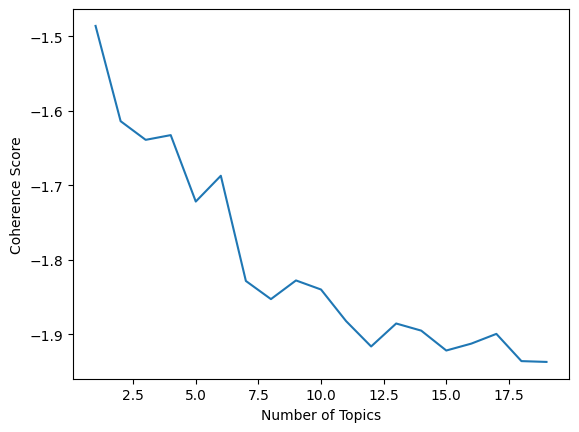

In [20]:
topics = []
score = []
for i in range(1,20,1):
    lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 16, passes=10, random_state=100)
    cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
    topics.append(i)
    score.append(cm.get_coherence())
    
    
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')

plt.show()

In [22]:
topics = []
score = []

for i in range(1,20,1):
    lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 16, passes=10, random_state=100)
    cm = CoherenceModel(model=lda_model, texts = paroles['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v')
    topics.append(i)
    score.append(cm.get_coherence())
    
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

KeyboardInterrupt: 

In [23]:
lda_model = LdaMulticore(
    corpus=corpus,
    id2word=dictionary,
    iterations=100,
    num_topics=12,
    workers = 16,
    passes=100
)

In [25]:
lda_model.save('models/lda-paroles')

In [24]:
lda_model.print_topics(-1)

[(0,
  '0.018*"public" + 0.014*"loi" + 0.013*"travail" + 0.012*"été" + 0.012*"national" + 0.012*"social" + 0.011*"service" + 0.011*"permettre" + 0.011*"sécurité" + 0.010*"mission"'),
 (1,
  '0.039*"projet" + 0.032*"loi" + 0.031*"énergie" + 0.022*"avoir" + 0.018*"texte" + 0.015*"débat" + 0.014*"renouvelable" + 0.012*"faire" + 0.012*"énergétiqu" + 0.011*"nucléaire"'),
 (2,
  '0.107*"ministre" + 0.099*"m." + 0.080*"monsieur" + 0.058*"parole" + 0.052*"mme" + 0.024*"règlement" + 0.023*"question" + 0.022*"délégué" + 0.022*"commission" + 0.020*"rapporteur"'),
 (3,
  '0.031*"territoire" + 0.017*"local" + 0.015*"-" + 0.014*"commune" + 0.014*"zone" + 0.011*"collectivité" + 0.011*"agricole" + 0.010*"eau" + 0.009*"élu" + 0.009*"état"'),
 (4,
  '0.128*"groupe" + 0.118*"banc" + 0.083*"-" + 0.075*"applaudissement" + 0.074*"nupes" + 0.045*"lfi" + 0.029*"re" + 0.018*"écolo" + 0.018*"rn" + 0.016*"dem"'),
 (5,
  '0.117*"amendement" + 0.059*"national" + 0.058*"groupe" + 0.048*"assemblée"

In [29]:
len(corpus)

69498

In [58]:
paroles.reset_index().index.to_numpy()

array([    0,     1,     2, ..., 69495, 69496, 69497])

In [41]:
sorted(lda_model[corpus][69497])

[(1, 0.6551095), (4, 0.2689713), (5, 0.047070798)]

In [61]:
paroles_topic = (
    paroles
    .assign(
#        topic = lambda df: df.reset_index(drop=True).apply(lambda r: sorted(lda_model[corpus][r.name])[0][0], axis=1)
        topic = lambda df: [ sorted(lda_model[corpus][idx])[0][0] for idx in paroles.reset_index().index.to_numpy()] #df.reset_index().apply(lambda r: r.name, axis=1)
    )
)

paroles_topic

,id_syceron,acteur,code_grammaire,code_style,stime,texte,seance,mots,tokens,topic
2,2845797,PA721908,PAROLE_GENERIQUE,NORMAL,931.96,"La parole est à M. Jean-Renvé Cazeneuve, rap...",RUANR5L16S2022IDS26244,13,"[parole, m., jean, -, renvé, cazeneuve, rappo...",0
3,2845798,PA719472,PAROLE_GENERIQUE,NORMAL,957.22,Je suis ravi de vous présenter les conclusion...,RUANR5L16S2022IDS26244,101,"[ravir, présenter, conclusion, commission, mi...",1
5,2845800,PA719472,PAROLE_GENERIQUE,NORMAL,983.07,Les discussions franches et efficaces que nous...,RUANR5L16S2022IDS26244,110,"[discussion, franc, efficace, avoir, permettre...",0
8,2845803,PA719472,PAROLE_GENERIQUE,NORMAL,1025.37,...la revalorisation du point d’indice de la f...,RUANR5L16S2022IDS26244,72,"[revalorisation, point, indice, fonction, publ...",6
10,2845805,PA719472,PAROLE_GENERIQUE,NORMAL,1052.58,"À ceux qui, ici, avec mauvaise foi et parfois...",RUANR5L16S2022IDS26244,60,"[à, mauvais, foi, condescendance, dire, miett...",4
...,...,...,...,...,...,...,...,...,...,...
156962,2944883,PA793382,PAROLE_GENERIQUE,NORMAL,9384.75,Cela vaut aussi pour d’autres collègues. Le s...,RUANR5L16S2023IDS26598,47,"[valoir, collègue, sujet, savoir, savoir, ver...",3
156964,2945096,PA795778,PAROLE_GENERIQUE,NORMAL,9410.20,"Vous ne m’avez pas répondu, madame Pannier-Ru...",RUANR5L16S2023IDS26598,156,"[avoir, répondu, monsieur, pannier, -, runach...",1
156966,2945099,PA795778,PAROLE_GENERIQUE,NORMAL,9466.82,...tandis qu’un mix avec moins d’énergies ren...,RUANR5L16S2023IDS26598,60,"[mix, énergie, renouvelable, france, être, d...",1
156968,2944886,PA794008,PAROLE_GENERIQUE,NORMAL,9487.18,Je veux dire au Rassemblement national que nou...,RUANR5L16S2023IDS26598,66,"[vouloir, rassemblement, national, feuille, ro...",3


In [62]:
paroles_topic.query('topic == 1')[['texte']]

,texte
3,Je suis ravi de vous présenter les conclusion...
25,À ceux qui n’ont cessé de répéter tout au ...
29,La parole est à M. le ministre de l’économie...
57,"...quant au compromis, nous l’avons non pas ac..."
98,Des vérités ont bel et bien éclaté à la f...
...,...
156958,Je veux bien qu’on nous accuse de répéter le...
156960,...mais nous n’en voulons pas à n’importe que...
156964,"Vous ne m’avez pas répondu, madame Pannier-Ru..."
156966,...tandis qu’un mix avec moins d’énergies ren...


In [90]:
paroles_topic.query('topic == 4')[['texte']]

,texte
10,"À ceux qui, ici, avec mauvaise foi et parfois..."
12,N’oublions pas que ce sont les mêmes qui cria...
14,Quant à nos collègues socialistes et communi...
16,Où est votre cohérence ? (Exclamations sur l...
20,Il n’aura échappé à personne que le texte i...
...,...
156443,Lorsqu’une mesure est bonne pour les Français...
156681,"...soit, effectivement, nous modifions le text..."
156685,Je le répète : cela n’a strictement aucun se...
156746,"Sur l’amendement no 3039, je suis saisie par l..."


In [64]:
paroles_topic.topic.value_counts()

0     28767
1     10420
2      9461
4      7692
3      5115
7      2513
5      2500
6      1709
9       513
8       463
11      201
10      144
Name: topic, dtype: int64

In [66]:
paroles_topic.topic.isna().sum()

0

In [77]:
deputes = (
    votes
    .groupby(['acteurRef', 'organe'])
    .agg({'scrutin' : 'count' })
    .reset_index()
    .join(organes.set_index('uid')[['libelleAbrev']], on='organe')
    .set_index('acteurRef')
)

deputes

,organe,scrutin,libelleAbrev
acteurRef,,,
PA1008,PO800496,539,SOC
PA1206,PO793087,119,NI
PA1327,PO800508,309,LR
PA1567,PO800496,410,SOC
PA1592,PO793087,122,NI
...,...,...,...
PA817203,PO800538,358,RE
PA817211,PO800490,386,LFI-NUPES
PA822617,PO793087,21,NI


In [89]:
(
    paroles_topic
    .join(deputes, on='acteur')
    .pivot_table(
        index='libelleAbrev',
        columns='topic',
        values='id_syceron',
        aggfunc='count'
    )
    .pipe(lambda df: df.div(df.sum(axis=1), axis=0))
    .style.background_gradient(axis=1)
)

topic,0,1,2,3,4,5,6,7,8,9,10,11
libelleAbrev,,,,,,,,,,,,
DEM,0.418333,0.130615,0.157102,0.060244,0.097897,0.071670,0.011685,0.032719,0.006232,0.008050,0.001558,0.003895
ECOLO,0.342540,0.208232,0.139724,0.092878,0.133496,0.019496,0.012727,0.028161,0.008665,0.009477,0.001354,0.003249
GDR-NUPES,0.373065,0.189241,0.148607,0.095201,0.115325,0.015867,0.017415,0.025542,0.006192,0.007740,0.003096,0.002709
HOR,0.482759,0.112428,0.145833,0.066810,0.056034,0.086207,0.011853,0.026940,0.003592,0.002874,0.001078,0.003592
LFI-NUPES,0.356889,0.149448,0.157655,0.060272,0.172518,0.036291,0.021063,0.022431,0.007203,0.010395,0.002735,0.003100
LIOT,0.398615,0.163699,0.160237,0.119683,0.059842,0.026212,0.034125,0.027695,0.003462,0.003956,0.001484,0.000989
LR,0.356983,0.169460,0.152700,0.102235,0.090875,0.029609,0.032961,0.041713,0.011918,0.006890,0.002048,0.002607
NI,0.373235,0.176866,0.122394,0.088097,0.117014,0.024210,0.032280,0.039005,0.007397,0.010087,0.004035,0.005380
RE,0.422650,0.138871,0.119452,0.077350,0.093342,0.035003,0.032882,0.066335,0.004569,0.006038,0.001305,0.002203
